In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import seaborn as sns

G = nx.read_gml("GraphMissingEdges.gml")

In [2]:
print("Number of nodes:", len(G.nodes))
print("Number of edges:", len(G.edges))

Number of nodes: 4575
Number of edges: 18991


In [3]:
print("Attributes of each node:")
print(G.nodes[list(G.nodes())[900]])

Attributes of each node:
{'longitude': -79.952564, 'latitude': 40.481878, 'categories': '327,518', 'stars': '4.5', 'name': 'The Cigar Den', 'reviewCount': '28'}


In [4]:
print("Attributes of each edge:")
print(G.edges[list(G.edges())[20]])

Attributes of each edge:
{'weight': 1}


In [5]:
print(f"Average clustering: {nx.average_clustering(G)}")

Average clustering: 0.04489358044799769


In [6]:
all_categories = []
for node, data in G.nodes(data=True):
    cats = [c.strip() for c in data["categories"].split(",")]
    all_categories.extend(cats)

cat_counts = pd.Series(all_categories).value_counts()

print("Top 10 categories:")
print(cat_counts.head(10))

Top 10 categories:
1      1681
641     907
327     731
58      504
275     467
280     404
839     364
133     298
289     290
604     286
Name: count, dtype: int64


In [7]:
cat_edges = Counter()
for u, v in G.edges():
    cats_u = [c.strip() for c in G.nodes[u]["categories"].split(",")]
    cats_v = [c.strip() for c in G.nodes[v]["categories"].split(",")]
    for cu in cats_u:
        for cv in cats_v:
            if cu != "" and cv != "":
                pair = tuple(sorted([cu, cv]))
                cat_edges[pair] += 1

cat_edges_df = pd.DataFrame(cat_edges.items(), columns=["Connection", "Count"])
cat_edges_df = cat_edges_df.sort_values("Count", ascending=False).reset_index(drop=True)
print("Top 10 category-category connections:")
print(cat_edges_df.head(10))

Top 10 category-category connections:
   Connection  Count
0      (1, 1)  10681
1    (1, 641)   8983
2     (1, 58)   7303
3    (1, 275)   7105
4    (1, 420)   4760
5    (1, 604)   3947
6   (58, 641)   2985
7   (275, 58)   2955
8  (275, 641)   2899
9    (1, 289)   2853


In [8]:
star_edges = Counter()
for u, v in G.edges():
    stars_u = G.nodes[u]["stars"]
    stars_v = G.nodes[v]["stars"]
    
    if stars_u != "" and stars_v != "":
        pair = tuple(sorted([stars_u, stars_v]))
        star_edges[pair] += 1
    
star_edges_df = pd.DataFrame(star_edges.items(), columns=["Connection", "Count"])
star_edges_df = cat_edges_df.sort_values("Count", ascending=False).reset_index(drop=True)
print("Top 10 star-star connections:")
print(cat_edges_df.head(10))

Top 10 star-star connections:
   Connection  Count
0      (1, 1)  10681
1    (1, 641)   8983
2     (1, 58)   7303
3    (1, 275)   7105
4    (1, 420)   4760
5    (1, 604)   3947
6   (58, 641)   2985
7   (275, 58)   2955
8  (275, 641)   2899
9    (1, 289)   2853


In [9]:
review_count_edges = Counter()
for u, v in G.edges():
    rc_u = G.nodes[u]["reviewCount"]
    rc_v = G.nodes[v]["reviewCount"]
    
    if rc_u != "" and rc_v != "":
        pair = tuple(sorted([rc_u, rc_v]))
        review_count_edges[pair] += 1
    
review_count_edges_df = pd.DataFrame(review_count_edges.items(), columns=["Connection", "Count"])
review_count_edges_df = review_count_edges_df.sort_values("Count", ascending=False).reset_index(drop=True)
print("Top 10 review-count connections:")
print(review_count_edges_df.head(10))

Top 10 review-count connections:
  Connection  Count
0     (3, 3)     20
1     (3, 4)     19
2     (3, 5)     17
3   (15, 15)     14
4     (4, 5)     14
5     (5, 5)     11
6     (6, 8)     11
7     (6, 6)     10
8   (18, 18)     10
9     (4, 4)      9


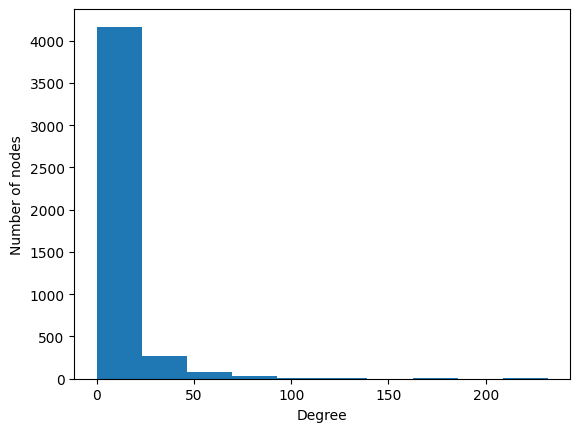

In [10]:
degrees = [d for n, d in G.degree()]
plt.hist(degrees, bins=10)
plt.xlabel("Degree")
plt.ylabel("Number of nodes")

plt.show()

In [11]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, k=1000) 
closeness_centrality = nx.closeness_centrality(G)

df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient="index")
df_nodes["degree"] = [G.degree(n) for n in G.nodes()]
df_nodes["degree_centrality"] = [degree_centrality[n] for n in G.nodes()]
df_nodes["betweenness_centrality"] = [betweenness_centrality[n] for n in G.nodes()]
df_nodes["closeness_centrality"] = [closeness_centrality[n] for n in G.nodes()]

df_nodes["stars"] = pd.to_numeric(df_nodes["stars"], errors="coerce")
df_nodes["reviewCount"] = pd.to_numeric(df_nodes["reviewCount"], errors="coerce")

df_nodes["num_categories"] = df_nodes["categories"].apply(lambda x: len([c.strip() for c in x.split(",") if c.strip()]))
df_nodes["primary_category"] = df_nodes["categories"].apply(lambda x: x.split(",")[0].strip() if x.strip() else "Unknown")

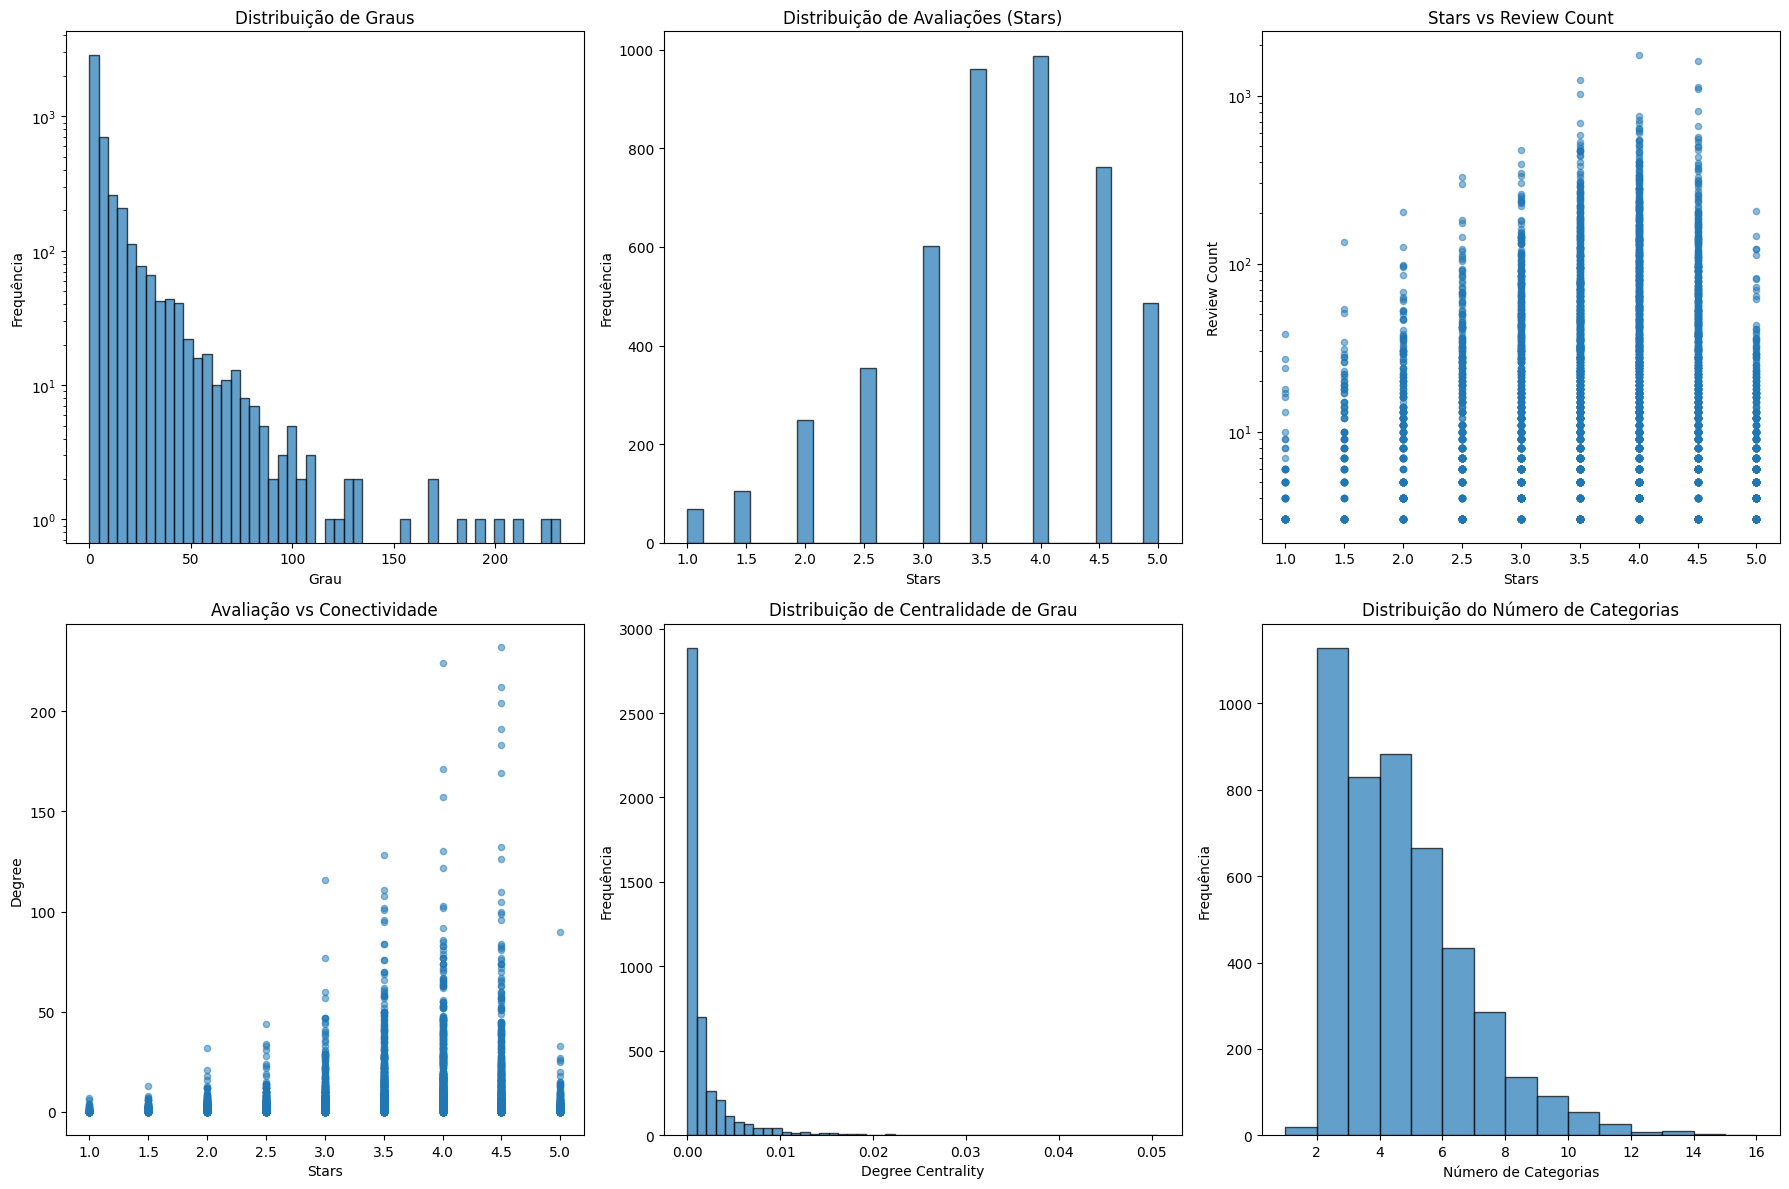

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0,0].hist(df_nodes["degree"], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Degree')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Degree Distribution')
axes[0,0].set_yscale('log')

axes[0,1].hist(df_nodes["stars"].dropna(), bins=30, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Stars')
axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Stars Distri')

valid_data = df_nodes.dropna(subset=['stars', 'reviewCount'])
axes[0,2].scatter(valid_data["stars"], valid_data["reviewCount"], alpha=0.5, s=20)
axes[0,2].set_xlabel('Stars')
axes[0,2].set_ylabel('Review Count')
axes[0,2].set_title('Stars vs Review Count')
axes[0,2].set_yscale('log')

axes[1,0].scatter(valid_data["stars"], valid_data["degree"], alpha=0.5, s=20)
axes[1,0].set_xlabel('Stars')
axes[1,0].set_ylabel('Degree')
axes[1,0].set_title('Reviews vs Connectivity')

axes[1,1].hist(df_nodes["degree_centrality"], bins=50, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Degree Centrality')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Degree Centrality Distribution')

axes[1,2].hist(df_nodes["num_categories"], bins=range(1, df_nodes["num_categories"].max()+2), 
               alpha=0.7, edgecolor='black')
axes[1,2].set_xlabel('Number of categories')
axes[1,2].set_ylabel('Frequency')
axes[1,2].set_title('Categories Distribution')

plt.tight_layout()
plt.show()